In [ ]:
pip install datasets

In [ ]:
pip install transformers

In [1]:

from transformers import AutoTokenizer
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import sleep
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Gameplay_Images")

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset = dataset["train"].train_test_split(0.2, seed=42, stratify_by_column="label")

In [4]:
jitter = Compose(
    [ ToTensor()]
)

In [6]:
def transforms(examples):

    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]

    return examples

In [7]:
dataset = dataset.with_transform(transforms)

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

In [9]:
def collate_fn(examples):

    images = []

    labels = []

    for example in examples:

        images.append((example["pixel_values"]))

        labels.append(example["label"])

        

    pixel_values = torch.stack(images)

    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}

train_dataloader = DataLoader(dataset["train"], collate_fn=collate_fn, batch_size=batch_size)
val_dataloader =  DataLoader(dataset["test"], collate_fn=collate_fn, batch_size=batch_size)

In [10]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [11]:
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
tr = model.train()

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})

In [14]:
train_accu = []
train_losses = []

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in data:
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss=running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [15]:
eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in data:
          # Move input and label tensors to the device
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss=running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))


In [16]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1
Train Loss: 0.216 | Accuracy: 95.463
Val Loss: 0.038 | Accuracy: 98.900

Epoch : 2
Train Loss: 0.030 | Accuracy: 99.088
Val Loss: 0.027 | Accuracy: 99.300

Epoch : 3
Train Loss: 0.068 | Accuracy: 98.037
Val Loss: 0.050 | Accuracy: 98.300

Epoch : 4
Train Loss: 0.018 | Accuracy: 99.412
Val Loss: 0.015 | Accuracy: 99.500

Epoch : 5
Train Loss: 0.005 | Accuracy: 99.838
Val Loss: 0.017 | Accuracy: 99.500

Epoch : 6
Train Loss: 0.003 | Accuracy: 99.912
Val Loss: 0.013 | Accuracy: 99.600

Epoch : 7
Train Loss: 0.069 | Accuracy: 98.338
Val Loss: 0.114 | Accuracy: 97.150

Epoch : 8
Train Loss: 0.033 | Accuracy: 99.062
Val Loss: 0.042 | Accuracy: 99.100

Epoch : 9
Train Loss: 0.020 | Accuracy: 99.438
Val Loss: 0.026 | Accuracy: 99.250

Epoch : 10
Train Loss: 0.013 | Accuracy: 99.650
Val Loss: 0.021 | Accuracy: 99.500


In [17]:
import matplotlib.pyplot as plt

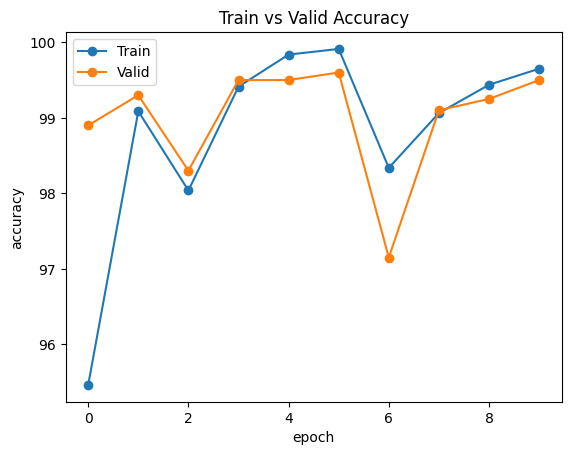

In [18]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

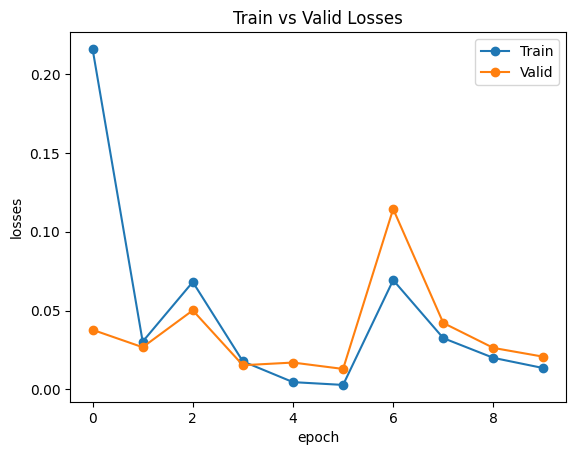

In [19]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [20]:
PATH = './bigust.pth'
torch.save(model.state_dict(), PATH)

In [21]:
from PIL import Image

model.eval()
image = Image.open('dow.jpg')
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = Compose([
    ToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor

img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    
    print(predicted)

tensor([6], device='cuda:0')


In [22]:
dataset["train"].features["label"].names[predicted]

'God of War'

In [23]:
model.eval()
image = Image.open('flob.jpg')
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = Compose([
    ToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor

img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    
    print(predicted)

tensor([7], device='cuda:0')


In [24]:
dataset["train"].features["label"].names[predicted]

'Minecraft'